In [6]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import glob

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (19.0, 17.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


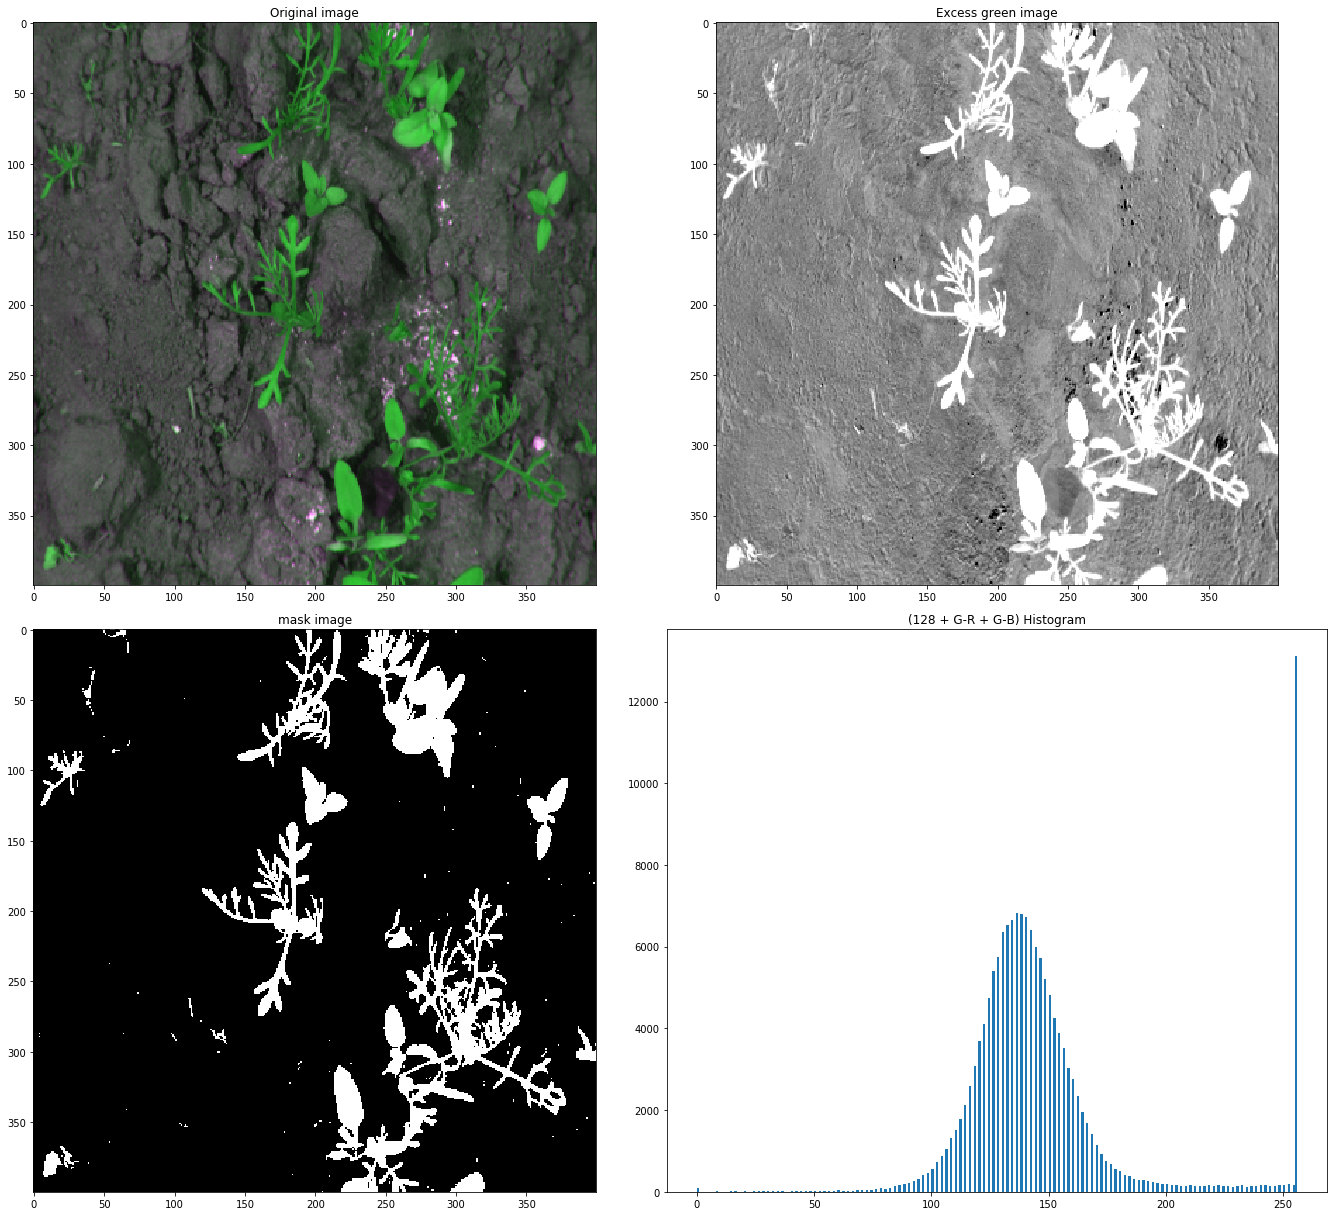

In [10]:




#read image 
p_origin = cv2.imread('../crop-image/crop-weed01.png')

p = cv2.resize(p_origin.copy(), (400,400))
# # %Red Component of Colour Image
# p_red = p[:,:,0]
# # %Green Component of Colour Image
# p_green= p[:,:,1]
# # %Blue Component of Colour Image
# p_blue= p[:,:,2]

p_blue, p_green, p_red= cv2.split(p) # For BGR image # For RGB image

# subtract out red and blue
#wrap around uint8 convention. this is a requrement for this algorithm 
# 0 - 4 = 0 (uint8 truncated)
p_excess_green = 128 + np.int16(p_green) - np.int16(p_blue) + np.int16(p_green) - np.int16(p_red)
p_excess_green = np.uint8(np.clip(p_excess_green, 0, 255))

mask = np.uint8((p_excess_green > 200)*1)


# hist = cv2.calcHist([p_excess_green],[0],None,[256],[0,256])
# plt.hist(p_excess_green.ravel(),256,[0,256])
# plt.show()

plt.subplot(2,2,1)
plt.title('Original image')
plt.imshow(p)


plt.subplot(2,2,2)
plt.imshow(p_excess_green)
plt.title('Excess green image')


plt.subplot(2,2,3)
plt.imshow(mask)
plt.title('mask image')

plt.subplot(2,2,4)
plt.title('(128 + G-R + G-B) Histogram')
plt.hist(p_excess_green.ravel(),256,[0,256]);

plt.tight_layout()
plt.show()


Draw contour


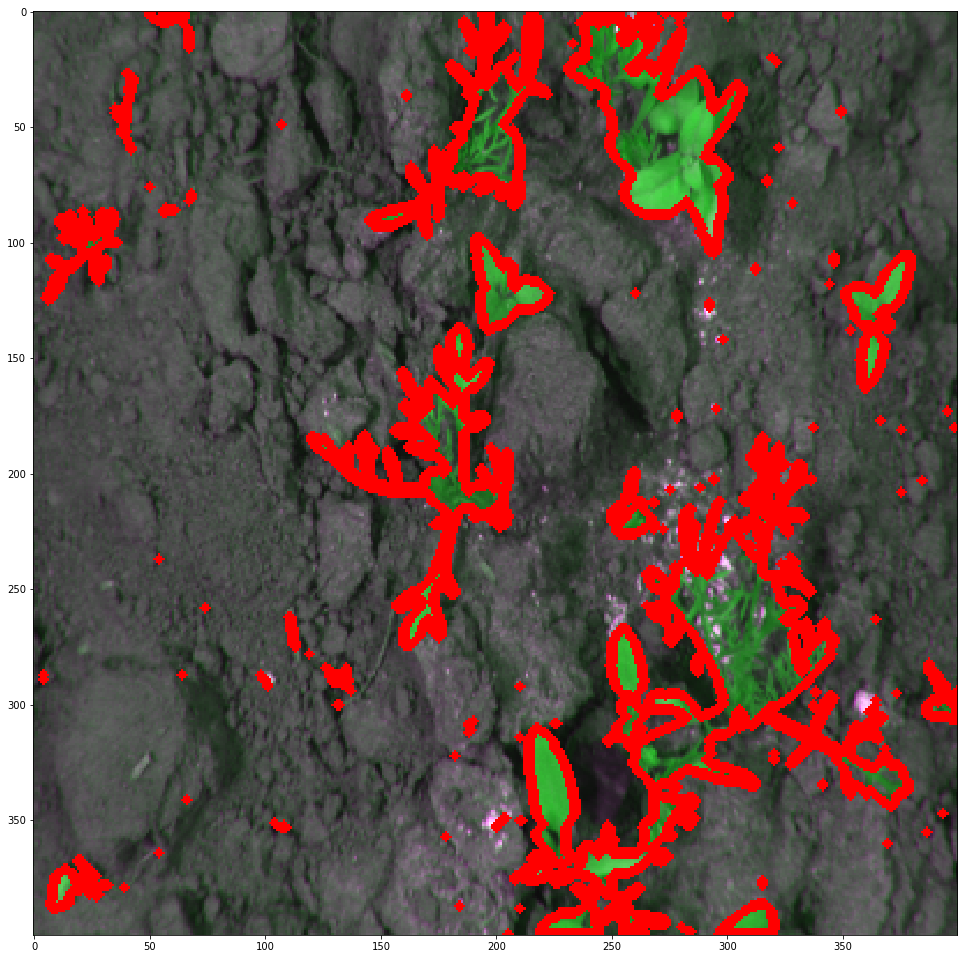

In [11]:
# #thresh hold for binary image 1,0
# thresh, im_bw = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY) #im_bw: binary image

p_contoured = p.copy()
#base on: https://mmeysenburg.github.io/image-processing/09-contours/
#cv2.RETR_TREE: mean all contour in the image 
#RETR_EXTERNAL: mean outer edge
im3, contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


#image with contours
print("Draw contour")
cv2.drawContours(p_contoured, contours, -1, (255,0,0), 3)
plt.imshow(p_contoured)
plt.show()

## Box Contour
- Find all boxes.
- remove overlaping boxes

### Find all boxes given contours vector 

Draw all Box on the screen


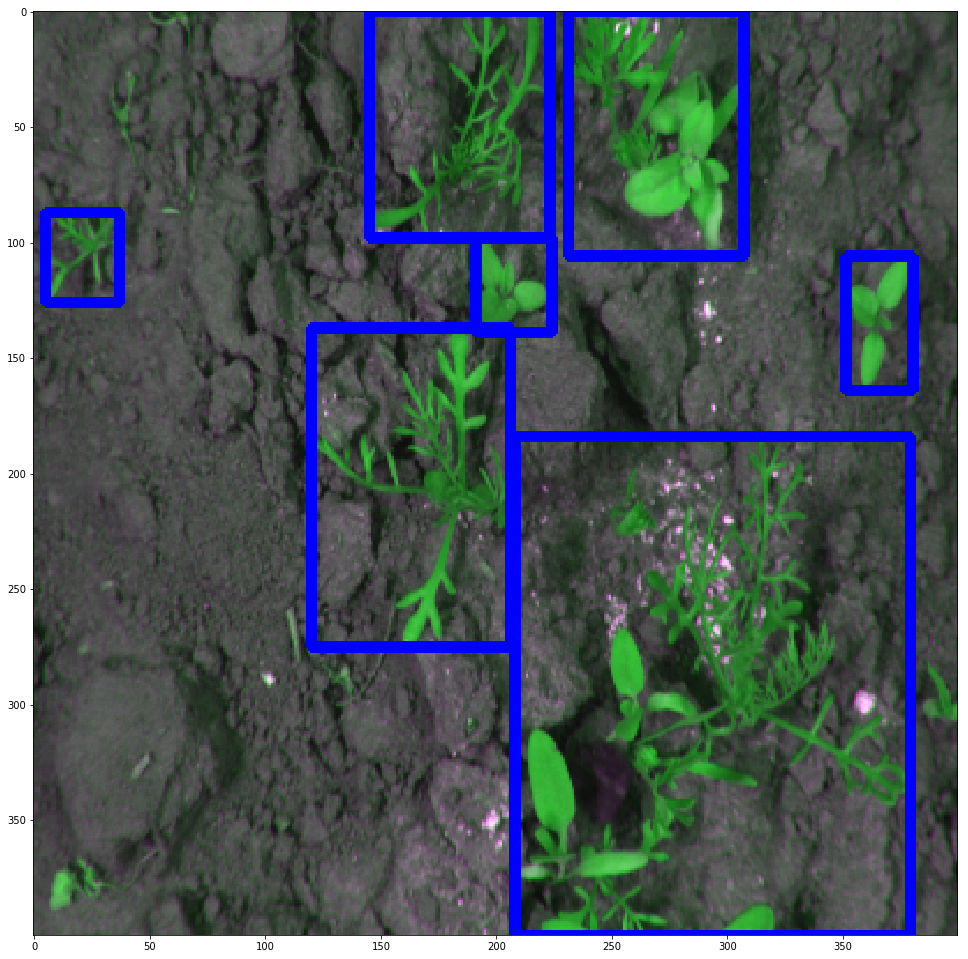

7
[(208, 184, 171, 216), (120, 137, 86, 138), (351, 106, 29, 58), (191, 98, 33, 41), (5, 87, 32, 39), (231, 0, 76, 106), (145, 0, 78, 98)]


In [12]:
#Get all bounding boxes 
boxes = []
for c in contours: 
    x,y,w,h = cv2.boundingRect(c)
    if(w > 20 and h > 20):#don't box item if it is too small 
        boxes.append((x,y,w,h))#(x,y,w,h)

p_temp = p.copy()
#Draw all boxes on the screen 
for box in boxes: 
    cv2.rectangle(p_temp,(box[0],box[1]), (box[0]+box[2], box[1]+box[3]), (0,0,255), 4)

print("Draw all Box on the screen")
plt.imshow(p_temp)
plt.show()

print(len(boxes))
print(boxes)


### Remove Overlaping boxes 

2
[(127, 0, 273, 355), (0, 1, 121, 347)]


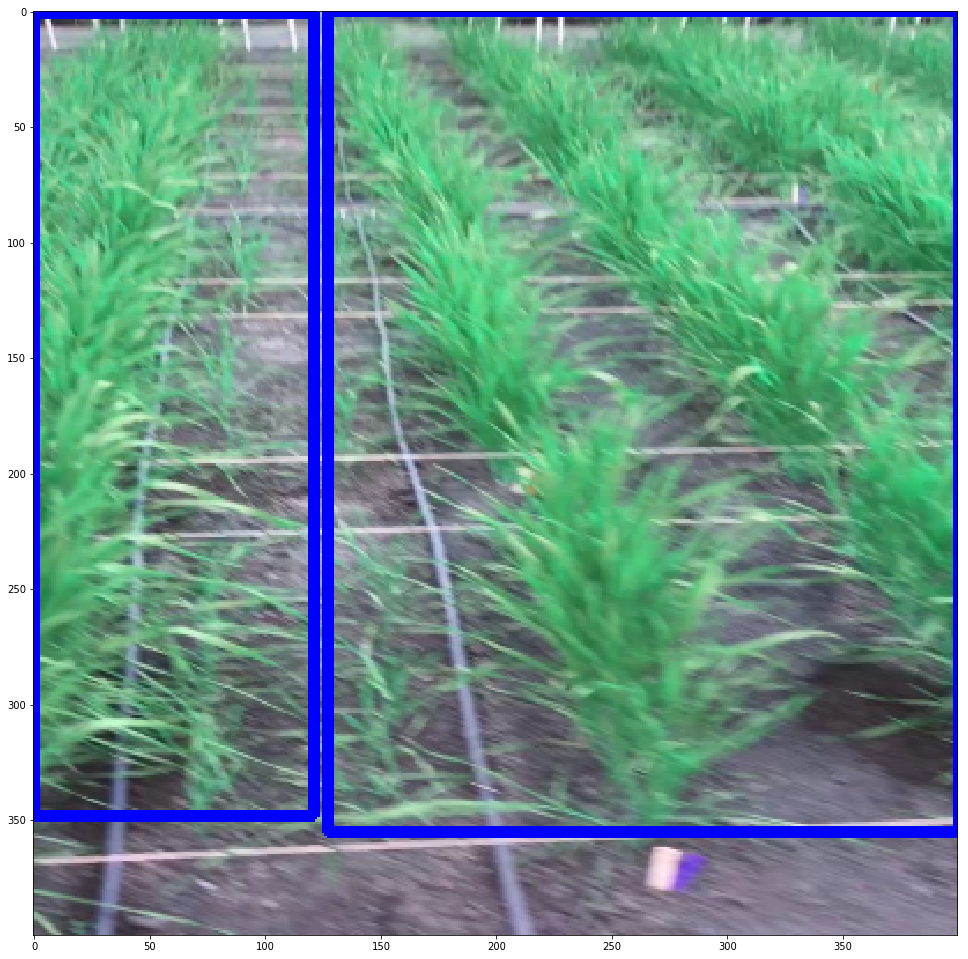

In [225]:
def overlap_area(box1, box2):
    '''
    box1: coordinate of box1(x,y,w,h) 
    box2: coor of box 2 
    return the overlaping area
    '''
    #unpack variable 
    x1, y1, w1, h1 = box1[0], box1[1], box1[2], box1[3]
    x2, y2, w2, h2 = box2[0], box2[1], box2[2], box2[3]
    
    w =  min(x1+w1, x2+w2)- max(x1, x2)
    h = min(y1+h1, y2+h2) - max(y1, y2)
    if(w < 0 or h < 0):
        return -1 # not overlap 
    return w * h # Overlap area


def is_enclosed(box1, box2): 
    '''
    assume rect is sort in x, box1.x < box2.x(only box2 can be enclosed in box1)
    if box1 > box2(box2 enclosed in box1) -> return 1 
    else: 0

    check if 2 box is 
    '''
    #unpack variable 
    x1, y1, w1, h1 = box1[0], box1[1], box1[2], box1[3]
    x2, y2, w2, h2 = box2[0], box2[1], box2[2], box2[3]
    #in other 2 box enclosed it need to be overlap as well
    if(x1+w1 >= x2+w2 and y1+h1 >= y2+h2 and overlap_area(box1, box2) > -1):# check box x and y 
        return True
    else: return False
    


def remove_overlap(boxes, axis=0, overlap_ratio=0.01): 
    '''
    boxes: list of tuple coordinate boxes[i] = (xi, yi, wi, hi) 
    overlap_ratio: if 2 boxes overlap area > one of the boxes area * overlap_ratio then remove that box
    This algorithm asumme that boxes is sorted by X correspond with boxes[0]
    '''
    i, j = 0, 0 
    if(len(boxes) == 1): return None
    while(j < len(boxes)-1 and i < len(boxes)): 
        if(i == j): i += 1 
        start = boxes[i][axis] 
        end = boxes[j][axis] + boxes[j][axis+2] #x + w 
        if(start < end): #check for overlap in x-dir
            #Unpack variable 
            xj, yj, wj, hj = boxes[j][0], boxes[j][1], boxes[j][2], boxes[j][3]
            xi, yi, wi, hi = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
            
            if(is_enclosed(boxes[j], boxes[i])):#assume it only possible if boxi enclosed in boxj
                boxes.remove(boxes[i]) 
                i = j
                continue 
            #check for overlap in y-dir  as well
            if(overlap_area(boxes[i], boxes[j]) > overlap_ratio * wi * hi or 
               overlap_area(boxes[i], boxes[j]) > overlap_ratio * wj * hj):
                #update new bouned box on boxj 
                #tuple is immutable therefore, cast it to list
                #reassign value then cast back to tuple
                box_join = list(boxes[j])
                box_join[0] = min(xi, xj)#X component 
                box_join[1] = min(yi, yj)#y component 
                box_join[2] = max(xi + wi, xj + wj) - box_join[0] #width
                box_join[3] = max(yi + hi, yj + hj) - box_join[1] # height
                boxes[j] = tuple(box_join)
                
                boxes.remove(boxes[i])
                i = j
                continue # we don't want to update i since removing element. index i will hold new element
            i += 1
        elif(start >= end): 
            i = j #reset counter so start checking down from j
            j += 1
'''
# print('is_enclosed beteen','a:',a,'b:',b,is_enclosed(arr[a], arr[b]))
remove_overlap(arr, axis=0, overlap_ratio = .1)
print('remove in x-dir',arr)

arr.sort(key=lambda tup: tup[1])  # sorts in place

remove_overlap(arr,axis=1,overlap_ratio = .1)
print('remove in y-dir',arr)
'''            


            
#sort boxes by x 
overlap_ratio = 0.6
boxes.sort(key=lambda tup: tup[0])  # sorts in place
remove_overlap(boxes, axis=0, overlap_ratio=overlap_ratio)

boxes.sort(key=lambda tup: tup[1])  # sorts in place by y
remove_overlap(boxes, axis=1, overlap_ratio=overlap_ratio)

print(len(boxes))
print(boxes)
p_boxed = p.copy()

for box in boxes:
    cv2.rectangle(p_boxed,(box[0],box[1]), (box[0]+box[2], box[1]+box[3]), (0,0,255), 4)# 4: 4 edges

plt.imshow(p_boxed)
plt.show()

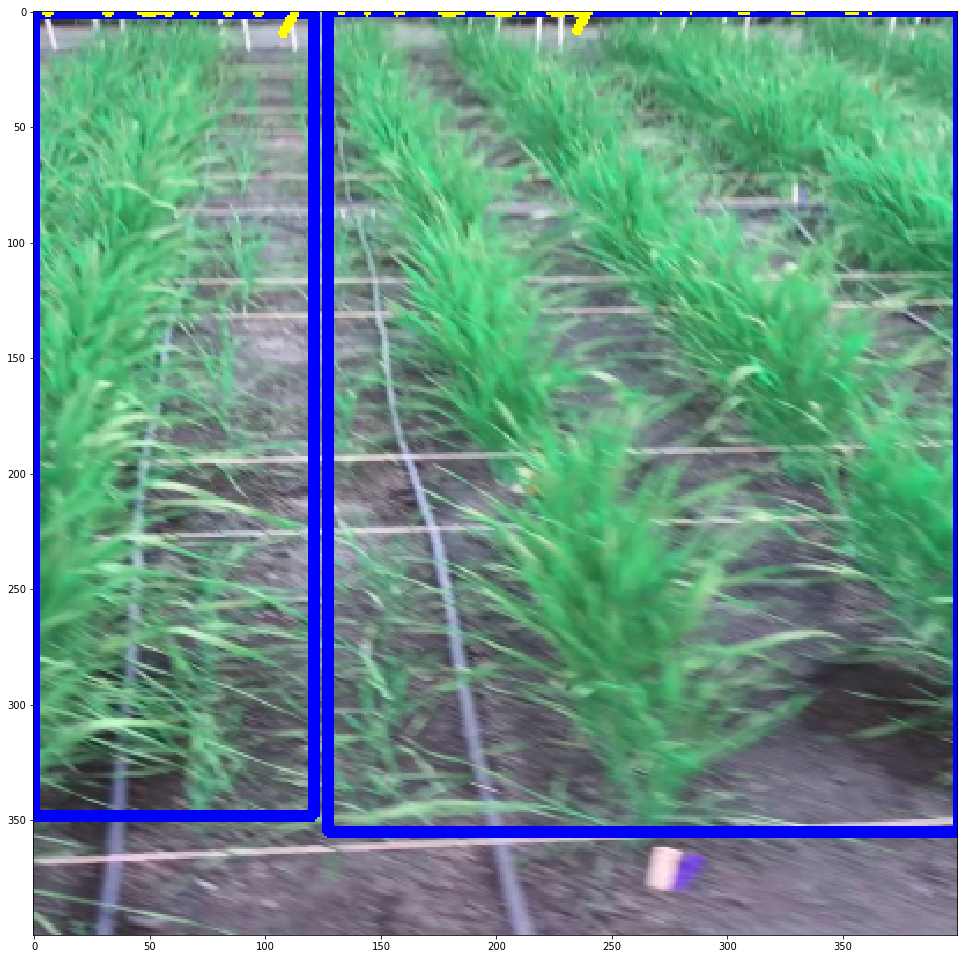

In [226]:
# put text on image 
font                   = cv2.FONT_HERSHEY_DUPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 1.3
fontColor              = (255,255,0)
lineType               = 2

p_texted = p.copy()
for box in boxes:
    cv2.rectangle(p_texted,(box[0],box[1]), (box[0]+box[2], box[1]+box[3]), (0,0,255), 4)# 4: 4 edges
    cv2.putText(p_texted,'Plant/Weed', 
                (box[0],box[1]), # bottom left corner
                font, 
                fontScale,
                fontColor,
                lineType)
    
plt.imshow(p_texted)
plt.show()

## Apply Algorithm to video with any size
- Idea: 
    - Resize input image using maxpool(Down sampling but keep important info) 
    - find contours and box coordinate
    - Translate those coordinate back
 

In [227]:
def translate(box, origin_h_w=(400,400), scale_h_w=(800,600)):
    '''
    box: tuple of shape (x,y,w,h) 
    origin_h_w: tuple shape (h, w)  
    scale_h_w: tupple shape (h, w)to scale
    return new box with given(height, width) scale
    '''
    h_scale, w_scale = scale_h_w[0]/origin_h_w[0], scale_h_w[1]/origin_h_w[1]
    return (int(box[0]*w_scale), int(box[1]*h_scale), int(box[2]*w_scale), int(box[3]*h_scale))

    
    

##### Map back boxes after preprocess to origin image

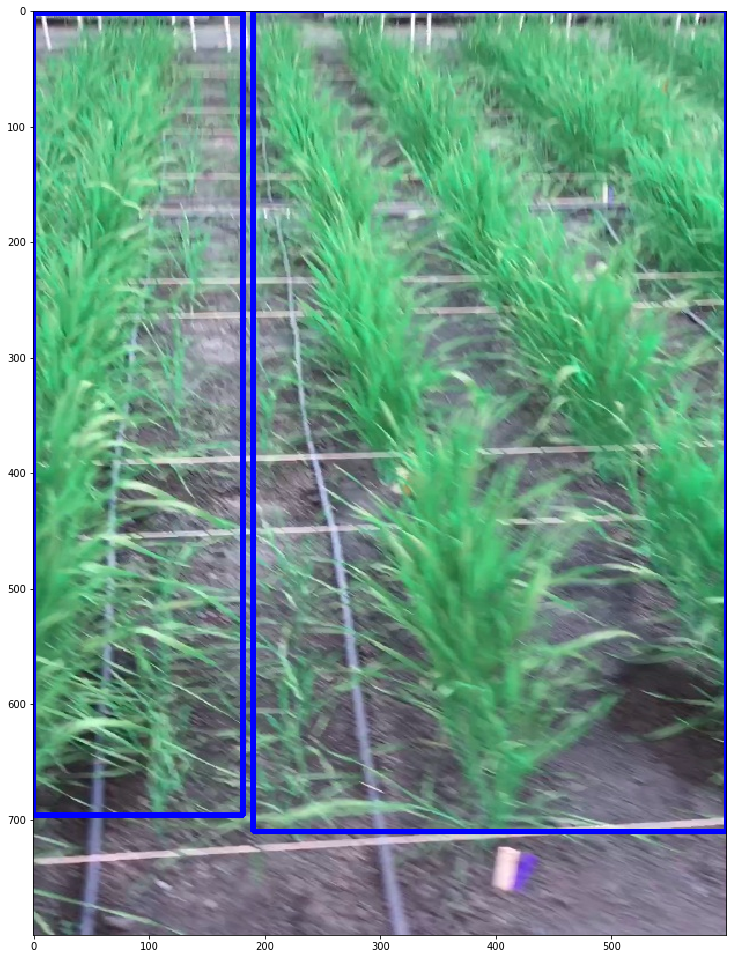

In [228]:
p_origin_draw = p_origin.copy()

for box in boxes:
    box = translate(box)
    cv2.rectangle(p_origin_draw,(box[0],box[1]), (box[0]+box[2],box[1]+box[3]), (0,0,255), 4)# 4: 4 edges
    
plt.imshow(p_origin_draw)

## Crop big box 

In [282]:

#find centroid of a mask image 
def find_centroid(mask):#crop by h, w
    h, w = mask.shape
    #find centroid 
    x_axis = np.arange(0,w,1)

    y_axis = np.arange(0,h,1) 
    x_v, y_v = np.meshgrid(x_axis, y_axis)

    Mx = x_v[mask.astype('bool')].mean()
    My = y_v[mask.astype('bool')].mean()
    return Mx, My
    
    
def crop_box(box, mask, x_fit = 200, y_fit = 200, y_drop_ratio=0.5, x_drop_ratio=0.5):# process image is 400,400
    '''
    mask: mask image
    '''
    x, y, w, h = box[0],box[1], box[2], box[3]
    x_fit = min(x_fit, w) 
    y_fit = min(y_fit, h)
    
    n_w = w // x_fit if (w // x_fit) is not 0 else 1 
    n_h = h // y_fit if (h // y_fit) is not 0 else 1 
    
    
    #take care of last box indepedently 
    last_region = (x+x_fit*n_w, y+y_fit*n_h, w%x_fit, h%y_fit)
    last_w_margin = max(w - x_fit*n_w, 0)
    last_h_margin = max(h - y_fit*n_h, 0)
    
    cropw = x_fit
    croph = y_fit 
    
    crop_region = []
    for xi in range(n_w + (1 if (last_w_margin > x_fit*x_drop_ratio) else 0)):
        for yi in range(n_h + (1 if(last_h_margin > y_fit*y_drop_ratio) else 0)):
            if(xi==n_w and (last_w_margin > x_fit*x_drop_ratio)):cropw = last_w_margin
            else: cropw = x_fit
                
            if(yi==n_h and (last_h_margin > y_fit*y_drop_ratio)):croph = last_h_margin 
            else: croph = y_fit
                
            crop_region.append([int(x+x_fit*xi), int(y+y_fit*yi), cropw, croph])
    
    print('before new COM',crop_region)
#     find centroid and shift the box to the centroid 
    for i in range(len(crop_region)):
        x_, y_, w_, h_ = crop_region[i]
        origin_comx, origin_comy = ((w_)/2)+x_, ((h_)/2)+y_
        new_comx, new_comy = find_centroid(mask[y_:y_+h_, x_:x_+w_])
        
        
        shift_x, shift_y = (x_+new_comx - origin_comx), (y_+new_comy - origin_comy)
        print("originxy:",origin_comx, origin_comy, "newcomxy",new_comx, new_comy,"shiftxy", shift_x, shift_y)
        crop_region[i][0] +=  int(shift_x)
        crop_region[i][1] +=  int(shift_y)

    return crop_region
    

before new COM [[127, 0, 150, 150]]
originxy: 202.0 75.0 newcomxy 78.89208922231897 71.43083930604863 shiftxy 3.8920892223189867 -3.5691606939513747
[[130, -3, 150, 150]]
(400, 400)


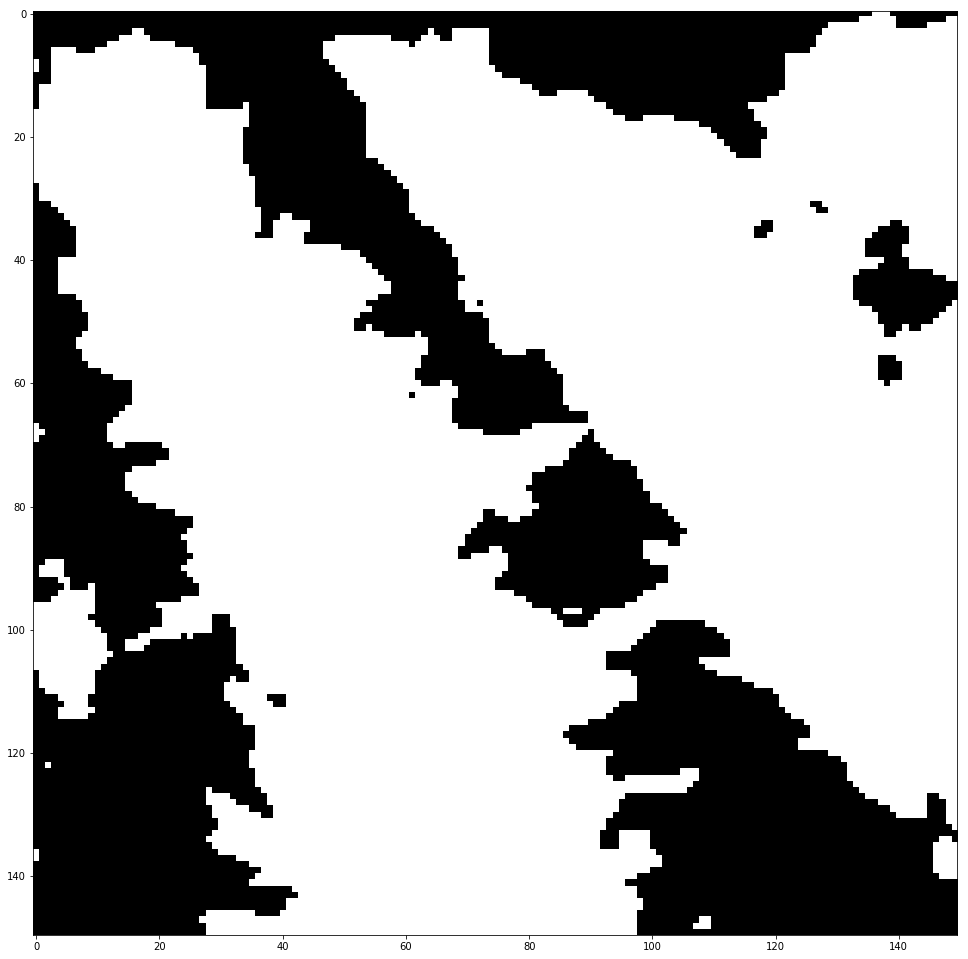

In [283]:
# [127, 0, 150, 150]
print(crop_box((127, 0, 150, 150), mask, x_fit = 150, y_fit = 150, y_drop_ratio= 0.5, x_drop_ratio = 0.5))
print(mask.shape)
plt.imshow(mask[ 0:0 + 150,127:127+150])

before crop (127, 0, 273, 355)
before new COM [[127, 0, 150, 150], [127, 150, 150, 150], [127, 300, 150, 55], [277, 0, 123, 150], [277, 150, 123, 150], [277, 300, 123, 55]]
originxy: 202.0 75.0 newcomxy 78.89208922231897 71.43083930604863 shiftxy 3.8920892223189867 -3.5691606939513747
originxy: 202.0 225.0 newcomxy 101.81526951851141 72.3926721657395 shiftxy 26.8152695185114 -2.607327834260502
originxy: 202.0 327.5 newcomxy 111.99718785151856 22.45556805399325 shiftxy 36.99718785151856 -5.044431946006739
originxy: 338.5 75.0 newcomxy 60.27634338138925 72.44220183486239 shiftxy -1.2236566186107325 -2.557798165137612
originxy: 338.5 225.0 newcomxy 69.0483188599421 59.10287241148965 shiftxy 7.548318859942128 -15.897127588510358
originxy: 338.5 327.5 newcomxy 13.299319727891156 15.120748299319727 shiftxy -48.200680272108855 -12.3792517006803
[[130, -3, 150, 150], [153, 148, 150, 150], [163, 295, 150, 55], [276, -2, 123, 150], [284, 135, 123, 150], [229, 288, 123, 55]]
BOxx
transalted [130,

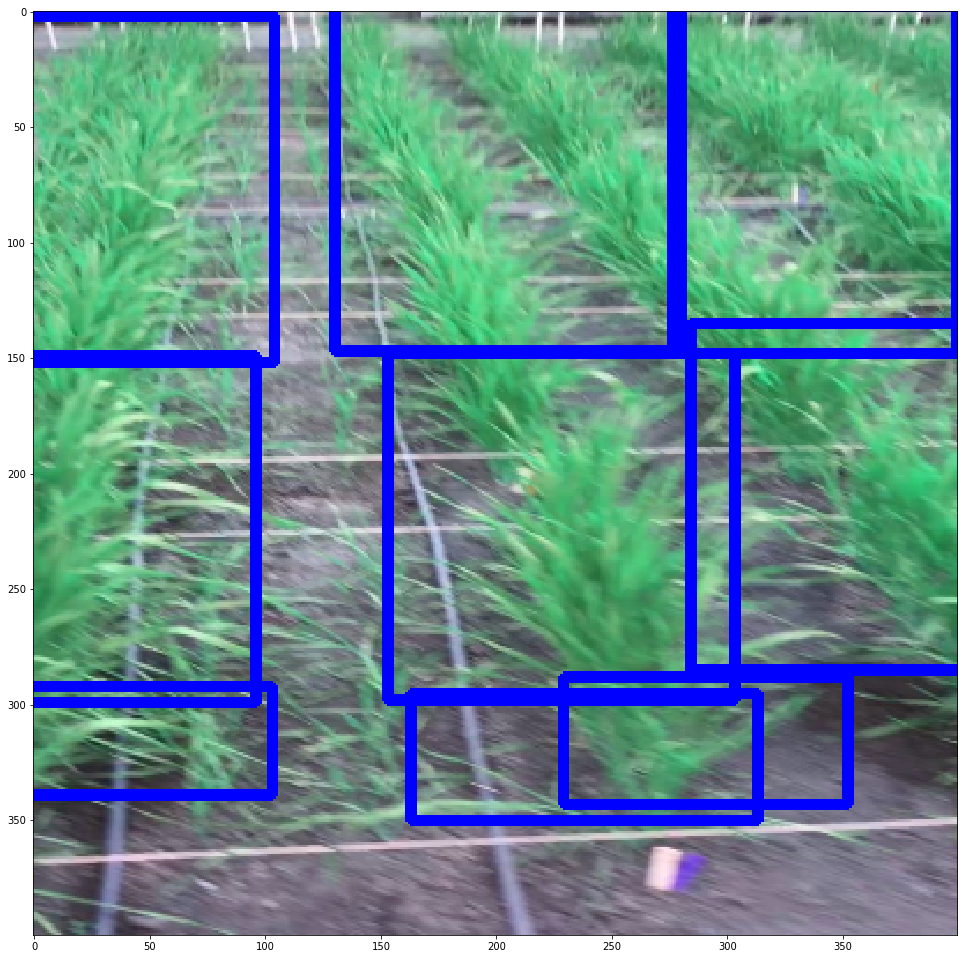

In [284]:
p__ = p_origin.copy()
p_small = p.copy()


for box in boxes:
    print("before crop", box)
    box = crop_box(box, mask, x_fit = 150, y_fit = 150, y_drop_ratio= 0.01, x_drop_ratio = 0.01)
    print(box)
    print('BOxx')
    for region in box: 
#         region = translate(region)
        print('transalted',region)
        cv2.rectangle(p_small,(region[0],region[1]), (region[0]+region[2],region[1]+region[3]), (0,0,255), 4)# 4: 4 edges
plt.imshow(p_small)

In [198]:
print(boxes)

[(0, 0, 94, 289), (95, 0, 157, 358), (178, 0, 222, 306)]


# Apply algorithm to video 
- Process video frame by frame and apply the algorithm 

In [ ]:
video = cv2.VideoCapture('../crop-image/wheat-video01.MOV')

count = 0 
while(video.isOpened()):
    ret, frame = video.read() #ret: bool
    frame=cv2.transpose(frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

In [39]:
w,h = mask.shape

x_axis = np.arange(0,w,1)
y_axis = np.arange(0,h,1) 
x_v, y_v = np.meshgrid(x_axis, y_axis) 


Mx = x_v[mask==1].mean()
My = y_v[mask==1].mean()

print(Mx)
print(My)

214.57555574531068
140.02477727492672


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([214.07555575, 214.17555575, 214.27555575, 214.37555575,
        214.47555575, 214.57555575, 214.67555575, 214.77555575,
        214.87555575, 214.97555575, 215.07555575]),
 <a list of 10 Patch objects>)

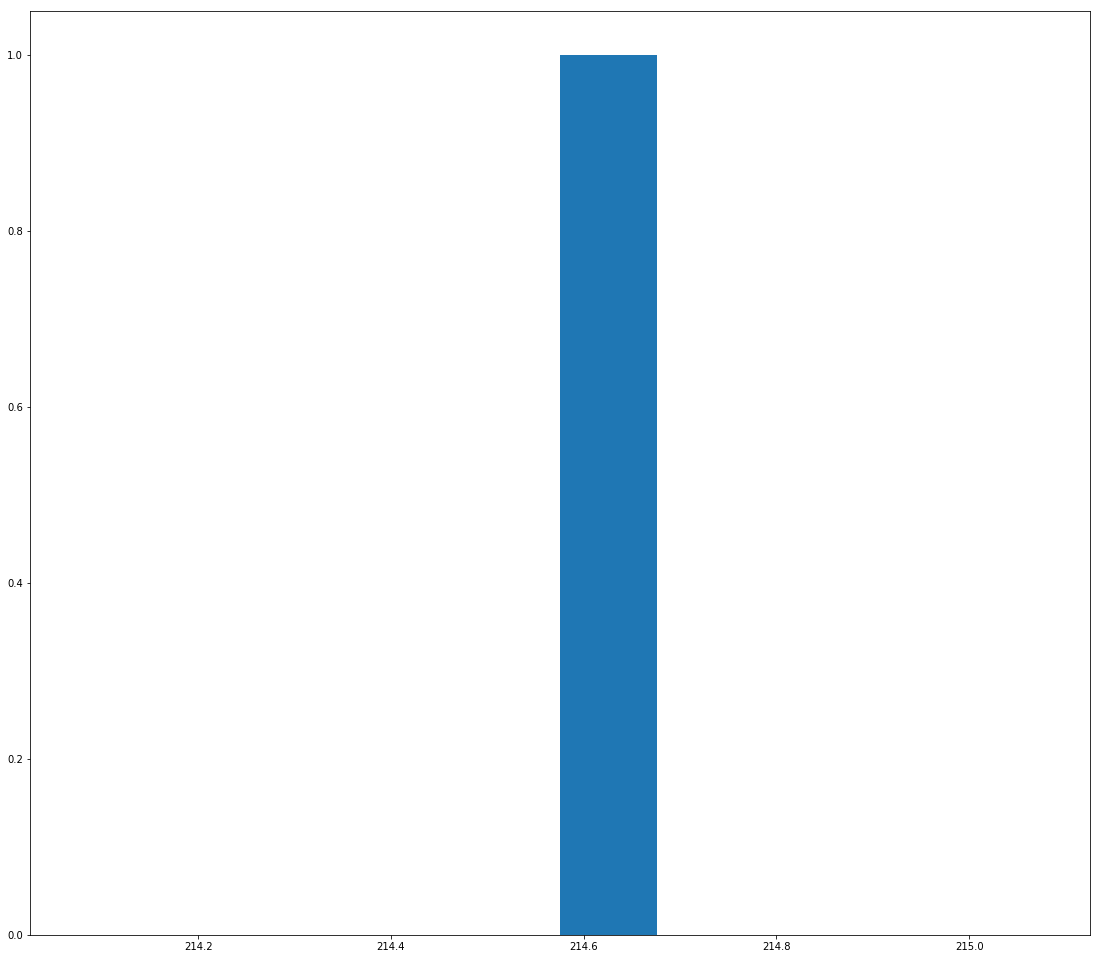

In [40]:
plt.hist(Mx)


In [108]:
img = cv2.imread(r'C:\Users\dnguyen52\Desktop\COMtest.png',0)
ret,thresh = cv2.threshold(img,127,255,0)
mask = thresh > 100

im2,contours,hierarchy = cv2.findContours(mask.astype('uint8'), 1, 2)
cnt = contours[0]
M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

print(cx, cy)

print('=========other method')

h, w = img.shape
#find centroid 
x_axis = np.arange(0,w,1)

y_axis = np.arange(0,h,1) 
x_v, y_v = np.meshgrid(x_axis, y_axis)

Mx = x_v[mask].mean()
My = y_v[mask].mean()

print(Mx)

print(My)


350 145
=========other method
199.27592259790194
134.03594265892087


In [141]:
def findCentroidLoop():
    Mx = 0.0
    My = 0.0 
    count = 0 
    for x in range(w):
        for y in range(h): 
            if(mask[y][x] == True):
                Mx += x
                My += y
                count += 1 #count total mass     
    print(Mx/count)
    print(My/count)
    
def findCentroidVec():
    h, w = img.shape
    #find centroid 
    x_axis = np.arange(0,w,1)

    y_axis = np.arange(0,h,1) 
    x_v, y_v = np.meshgrid(x_axis, y_axis)

    Mx = x_v[mask].mean()
    My = y_v[mask].mean()




199.27592259790194
134.03594265892087
199.27592259790194
134.03594265892087
loop 0.06250572204589844
vec 0.0


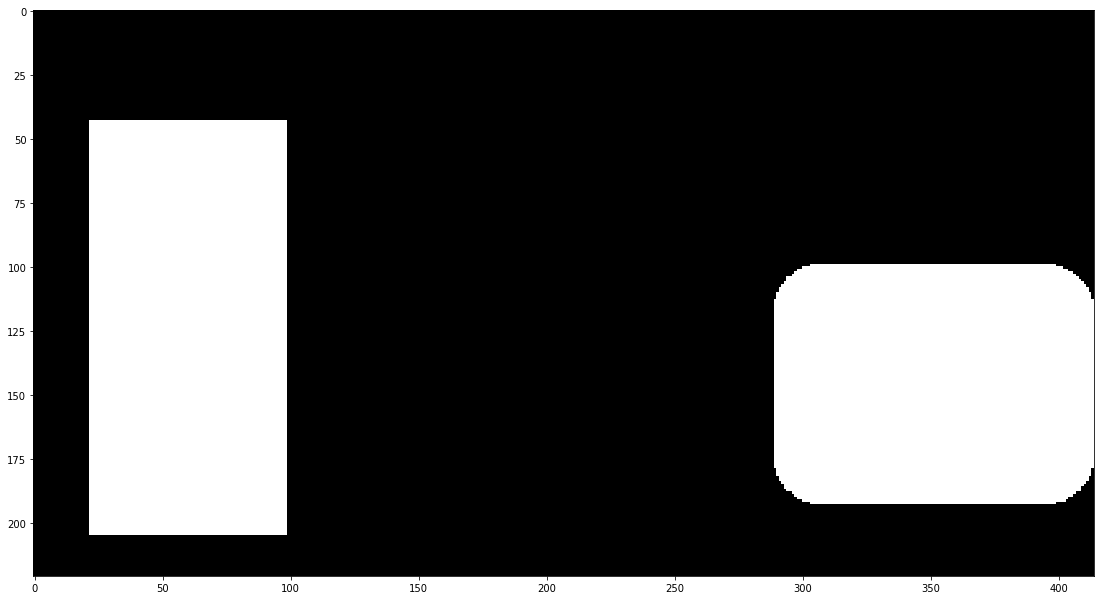

In [109]:
plt.imshow(mask)
